In [1]:
import os
from langchain_openai import AzureChatOpenAI
from dotenv import load_dotenv

load_dotenv()

llm = AzureChatOpenAI(
    api_version=os.getenv("AZURE_OPENAI_API_VERSION"),
    model="gpt-4o"
)

llm.invoke("안녕")

AIMessage(content='안녕하세요! 어떻게 도와드릴까요?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 11, 'prompt_tokens': 9, 'total_tokens': 20, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-05-13', 'system_fingerprint': 'fp_ee1d74bde0', 'id': 'chatcmpl-BU7KodLs7OHEXdAuSeUXlRXBs70JT', 'finish_reason': 'stop', 'logprobs': None, 'content_filter_results': {}}, id='run-0f818be6-9d74-42c7-9f60-63d2cc5ae3cb-0', usage_metadata={'input_tokens': 9, 'output_tokens': 11, 'total_tokens': 20, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

## 데이터베이스 채우기
- 다음 스크립트를 실행하여 이 튜토리얼을 위해 준비한 SQLite 데이터베이스를 가져오고, 현재 시점에 맞게 데이터를 업데이트하세요. 자세한 내용은 중요하지 않습니다.

In [2]:
import os
import shutil
import sqlite3

import pandas as pd
import requests

db_url = "https://storage.googleapis.com/benchmarks-artifacts/travel-db/travel2.sqlite"
local_file = "travel3.sqlite"
# 백업 파일은 각 튜토리얼 섹션을 다시 시작할 수 있도록 해줍니다
backup_file = "travel3.backup.sqlite"
overwrite = False
if overwrite or not os.path.exists(local_file):
    response = requests.get(db_url)
    response.raise_for_status()  # 요청이 성공했는지 확인
    with open(local_file, "wb") as f:
        f.write(response.content)
    # 백업 생성 - 각 섹션에서 DB를 "초기화"할 때 사용됩니다
    shutil.copy(local_file, backup_file)

## 항공편 데이터를 현재 시점으로 갱신

In [3]:
# 튜토리얼에서 사용하기 위해 항공편 일정을 현재 시점으로 맞춤
def update_dates(file):
    shutil.copy(backup_file, file)
    conn = sqlite3.connect(file)
    cursor = conn.cursor()

    # 데이터베이스 내 모든 테이블 이름 조회
    tables = pd.read_sql(
        "SELECT name FROM sqlite_master WHERE type='table';", conn
    ).name.tolist()
    tdf = {}
    for t in tables:
        tdf[t] = pd.read_sql(f"SELECT * from {t}", conn)

    # 예시 시간 추출 (가장 최근 실제 출발 시간 기준)
    example_time = pd.to_datetime(
        tdf["flights"]["actual_departure"].replace("\\N", pd.NaT)
    ).max()
    current_time = pd.to_datetime("now").tz_localize(example_time.tz)
    time_diff = current_time - example_time

    # 예약 날짜 갱신
    tdf["bookings"]["book_date"] = (
        pd.to_datetime(tdf["bookings"]["book_date"].replace("\\N", pd.NaT), utc=True)
        + time_diff
    )

    # 항공편의 날짜/시간 관련 컬럼들 갱신
    datetime_columns = [
        "scheduled_departure",
        "scheduled_arrival",
        "actual_departure",
        "actual_arrival",
    ]
    for column in datetime_columns:
        tdf["flights"][column] = (
            pd.to_datetime(tdf["flights"][column].replace("\\N", pd.NaT)) + time_diff
        )

    # 갱신된 데이터프레임을 다시 DB에 저장
    for table_name, df in tdf.items():
        df.to_sql(table_name, conn, if_exists="replace", index=False)
    del df
    del tdf
    conn.commit()
    conn.close()

    return file

# DB 갱신 실행
db = update_dates(local_file)

## Tools

이제 assistant가 사용할 도구들을 정의합니다. 이 도구들은 항공사의 정책 매뉴얼을 검색하고, 항공편·호텔·렌터카·현지 투어 예약을 검색하고 관리하는 기능을 제공합니다. 이 도구들은 튜토리얼 전반에서 재사용됩니다. 구현 세부사항은 중요하지 않으므로, 아래 코드를 실행하고 Part 1으로 넘어가도 괜찮습니다.

---

## Lookup Company Policies

assistant는 사용자 질문에 답변하기 위해 회사 정책 정보를 검색할 수 있습니다. 다만, 실제 정책을 **강제하는 로직은 반드시 해당 도구 또는 API 내부에서 수행**되어야 합니다. LLM은 정책을 무시할 수 있기 때문입니다.

In [4]:
import re

import numpy as np
import openai
from langchain_core.tools import tool

# 정책 FAQ 문서 다운로드
response = requests.get(
    "https://storage.googleapis.com/benchmarks-artifacts/travel-db/swiss_faq.md"
)
response.raise_for_status()
faq_text = response.text

# 각 섹션을 문서 단위로 나눔
docs = [{"page_content": txt} for txt in re.split(r"(?=\n##)", faq_text)]

# 벡터 검색기 정의
class VectorStoreRetriever:
    def __init__(self, docs: list, vectors: list, oai_client):
        self._arr = np.array(vectors)
        self._docs = docs
        self._client = oai_client

    @classmethod
    def from_docs(cls, docs, oai_client):
        # 문서 임베딩 생성
        embeddings = oai_client.embeddings.create(
            model="text-embedding-3-small", input=[doc["page_content"] for doc in docs]
        )
        vectors = [emb.embedding for emb in embeddings.data]
        return cls(docs, vectors, oai_client)

    def query(self, query: str, k: int = 5) -> list[dict]:
        # 쿼리 임베딩 생성
        embed = self._client.embeddings.create(
            model="text-embedding-3-small", input=[query]
        )
        # 임베딩 간 유사도 계산 (@"는 파이썬에서 행렬곱 연산)
        scores = np.array(embed.data[0].embedding) @ self._arr.T
        top_k_idx = np.argpartition(scores, -k)[-k:]
        top_k_idx_sorted = top_k_idx[np.argsort(-scores[top_k_idx])]
        return [
            {**self._docs[idx], "similarity": scores[idx]} for idx in top_k_idx_sorted
        ]

# 정책 검색기 인스턴스 생성
retriever = VectorStoreRetriever.from_docs(docs, openai.Client())

# 정책 검색 도구 정의
@tool
def lookup_policy(query: str) -> str:
    """특정 옵션이 허용되는지 확인하기 위해 회사 정책을 참조합니다.
    항공편 변경 등 '쓰기' 작업을 수행하기 전에 반드시 이 도구를 사용하세요."""
    docs = retriever.query(query, k=2)
    return "\n\n".join([doc["page_content"] for doc in docs])


## Flights

현재 사용자의 항공편 정보를 확인하기 위해 `fetch_user_flight_information` 툴을 정의합니다. 이후 SQL 데이터베이스에 저장된 승객의 예약을 검색 및 관리할 수 있는 툴들을 정의합니다.

In [5]:
import sqlite3
from datetime import date, datetime
from typing import Optional

import pytz
from langchain_core.runnables import RunnableConfig

### 사용자의 항공권 정보 조회

In [6]:
@tool
def fetch_user_flight_information(config: RunnableConfig) -> list[dict]:
    """사용자의 모든 항공권과 관련 항공편 및 좌석 정보를 조회합니다."""
    configuration = config.get("configurable", {})
    passenger_id = configuration.get("passenger_id", None)
    if not passenger_id:
        raise ValueError("No passenger ID configured.")

    conn = sqlite3.connect(db)
    cursor = conn.cursor()

    query = """
    SELECT
        t.ticket_no, t.book_ref,
        f.flight_id, f.flight_no, f.departure_airport, f.arrival_airport, f.scheduled_departure, f.scheduled_arrival,
        bp.seat_no, tf.fare_conditions
    FROM
        tickets t
        JOIN ticket_flights tf ON t.ticket_no = tf.ticket_no
        JOIN flights f ON tf.flight_id = f.flight_id
        JOIN boarding_passes bp ON bp.ticket_no = t.ticket_no AND bp.flight_id = f.flight_id
    WHERE
        t.passenger_id = ?
    """

    # 이 쿼리는 "특정 승객이 예약한 모든 항공권의 상세 정보(항공편, 좌석, 운임 등)"를 한 번에 조회하는 복합 쿼리입니다.
    # 실제 고객 지원 챗봇에서 "내 항공권 보여줘"와 같은 요청에 응답할 때 사용됩니다.

    cursor.execute(query, (passenger_id,))  # 쿼리를 실행하며, ? 자리에 passenger_id 값을 바인딩
    rows = cursor.fetchall()                # 쿼리 결과 전체를 리스트로 가져옴 (각 row는 튜플 형태)
    column_names = [column[0] for column in cursor.description]  # 결과 컬럼명 리스트 추출
    results = [dict(zip(column_names, row)) for row in rows]     # 각 row를 컬럼명과 매핑하여 dict로 변환

    cursor.close()  # 커서 자원 해제
    conn.close()    # 데이터베이스 연결 종료
    return results

"""
[
    {
        'ticket_no': '1234567890',
        'book_ref': 'BR1234',
        'flight_id': 101,
        'flight_no': 'LX123',
        'departure_airport': 'ZRH',
        'arrival_airport': 'JFK',
        'scheduled_departure': '2025-06-01 10:00:00+00:00',
        'scheduled_arrival': '2025-06-01 14:00:00+00:00',
        'seat_no': '12A',
        'fare_conditions': 'Economy'
    },
    {
        'ticket_no': '1234567890',
        'book_ref': 'BR1234',
        'flight_id': 102,
        'flight_no': 'LX456',
        'departure_airport': 'JFK',
        'arrival_airport': 'LAX',
        'scheduled_departure': '2025-06-02 09:00:00+00:00',
        'scheduled_arrival': '2025-06-02 12:00:00+00:00',
        'seat_no': '14C',
        'fare_conditions': 'Economy'
    },
    # ... 추가 항공권/항공편 정보 ...
]
"""

"\n[\n    {\n        'ticket_no': '1234567890',\n        'book_ref': 'BR1234',\n        'flight_id': 101,\n        'flight_no': 'LX123',\n        'departure_airport': 'ZRH',\n        'arrival_airport': 'JFK',\n        'scheduled_departure': '2025-06-01 10:00:00+00:00',\n        'scheduled_arrival': '2025-06-01 14:00:00+00:00',\n        'seat_no': '12A',\n        'fare_conditions': 'Economy'\n    },\n    {\n        'ticket_no': '1234567890',\n        'book_ref': 'BR1234',\n        'flight_id': 102,\n        'flight_no': 'LX456',\n        'departure_airport': 'JFK',\n        'arrival_airport': 'LAX',\n        'scheduled_departure': '2025-06-02 09:00:00+00:00',\n        'scheduled_arrival': '2025-06-02 12:00:00+00:00',\n        'seat_no': '14C',\n        'fare_conditions': 'Economy'\n    },\n    # ... 추가 항공권/항공편 정보 ...\n]\n"

### 항공편 검색

- search_flights 툴은 다양한 조건(출발지, 도착지, 시간 등)으로 항공편을 검색할 수 있는 기능입니다.
- 반환값은 각 항공편 정보를 담은 딕셔너리의 리스트입니다.
 - 실제 챗봇이나 서비스에서 "특정 날짜에 인천에서 뉴욕 가는 비행기 찾아줘"와 같은 요청에 활용할 수 있습니다.


In [7]:
@tool
def search_flights(
    departure_airport: Optional[str] = None,   # 출발 공항 코드(예: 'ICN'), 없으면 전체
    arrival_airport: Optional[str] = None,     # 도착 공항 코드(예: 'JFK'), 없으면 전체
    start_time: Optional[date | datetime] = None,  # 검색 시작 시각(이후 출발 항공편만)
    end_time: Optional[date | datetime] = None,    # 검색 종료 시각(이전 출발 항공편만)
    limit: int = 20,                              # 최대 반환 항공편 수
) -> list[dict]:
    """출발지, 도착지, 시간 범위로 항공편을 검색합니다."""
    conn = sqlite3.connect(db)                    # DB 연결 생성
    cursor = conn.cursor()                        # 커서 객체 생성

    query = "SELECT * FROM flights WHERE 1 = 1"   # 기본 쿼리(조건 추가를 위해 1=1 사용)
    params = []                                   # 쿼리 파라미터 리스트

    if departure_airport:                         # 출발 공항이 지정된 경우
        query += " AND departure_airport = ?"     # 쿼리에 조건 추가
        params.append(departure_airport)          # 파라미터에 값 추가

    if arrival_airport:                           # 도착 공항이 지정된 경우
        query += " AND arrival_airport = ?"       # 쿼리에 조건 추가
        params.append(arrival_airport)            # 파라미터에 값 추가

    if start_time:                                # 시작 시각이 지정된 경우
        query += " AND scheduled_departure >= ?"  # 쿼리에 조건 추가
        params.append(start_time)                 # 파라미터에 값 추가

    if end_time:                                  # 종료 시각이 지정된 경우
        query += " AND scheduled_departure <= ?"  # 쿼리에 조건 추가
        params.append(end_time)                   # 파라미터에 값 추가

    query += " LIMIT ?"                           # 결과 개수 제한
    params.append(limit)                          # 파라미터에 값 추가

    cursor.execute(query, params)                 # 쿼리 실행(파라미터 바인딩)
    rows = cursor.fetchall()                      # 결과 전체를 리스트로 가져옴
    column_names = [column[0] for column in cursor.description]  # 컬럼명 추출
    results = [dict(zip(column_names, row)) for row in rows]     # 각 row를 dict로 변환

    cursor.close()                                # 커서 자원 해제
    conn.close()                                  # DB 연결 종료

    return results                                # 결과 반환

"""
[
    {
        'flight_id': 101,
        'flight_no': 'LX123',
        'scheduled_departure': '2025-06-01 10:00:00+00:00',
        'scheduled_arrival': '2025-06-01 14:00:00+00:00',
        'departure_airport': 'ZRH',
        'arrival_airport': 'JFK',
        'status': 'On Time',
        'aircraft_code': '320',
        # ... (flights 테이블의 다른 컬럼이 있다면 추가)
    },
    {
        'flight_id': 102,
        'flight_no': 'LX456',
        'scheduled_departure': '2025-06-02 09:00:00+00:00',
        'scheduled_arrival': '2025-06-02 12:00:00+00:00',
        'departure_airport': 'JFK',
        'arrival_airport': 'LAX',
        'status': 'Delayed',
        'aircraft_code': '321',
        # ... (flights 테이블의 다른 컬럼이 있다면 추가)
    },
    # ... 추가 항공편 정보 ...
]
"""

"\n[\n    {\n        'flight_id': 101,\n        'flight_no': 'LX123',\n        'scheduled_departure': '2025-06-01 10:00:00+00:00',\n        'scheduled_arrival': '2025-06-01 14:00:00+00:00',\n        'departure_airport': 'ZRH',\n        'arrival_airport': 'JFK',\n        'status': 'On Time',\n        'aircraft_code': '320',\n        # ... (flights 테이블의 다른 컬럼이 있다면 추가)\n    },\n    {\n        'flight_id': 102,\n        'flight_no': 'LX456',\n        'scheduled_departure': '2025-06-02 09:00:00+00:00',\n        'scheduled_arrival': '2025-06-02 12:00:00+00:00',\n        'departure_airport': 'JFK',\n        'arrival_airport': 'LAX',\n        'status': 'Delayed',\n        'aircraft_code': '321',\n        # ... (flights 테이블의 다른 컬럼이 있다면 추가)\n    },\n    # ... 추가 항공편 정보 ...\n]\n"

### 항공권을 새 항공편으로 변경

- 이 툴은 "내 항공권을 다른 항공편으로 바꿔줘"와 같은 요청을 처리할 때 사용됩니다.
- 정책(출발 3시간 이내 불가, 소유자 확인 등)을 코드 내에서 강제합니다.
 - 모든 검증을 통과해야만 실제로 항공권이 새 항공편으로 변경됩니다.



In [8]:
@tool
def update_ticket_to_new_flight(
    ticket_no: str, new_flight_id: int, *, config: RunnableConfig
) -> str:
    """사용자의 항공권을 새 항공편으로 변경합니다."""
    configuration = config.get("configurable", {})                # config에서 설정값 추출
    passenger_id = configuration.get("passenger_id", None)        # 승객 ID 추출
    if not passenger_id:                                          # 승객 ID가 없으면 예외 발생
        raise ValueError("No passenger ID configured.")

    conn = sqlite3.connect(db)                                    # DB 연결 생성
    cursor = conn.cursor()                                        # 커서 객체 생성

    cursor.execute(
        "SELECT departure_airport, arrival_airport, scheduled_departure FROM flights WHERE flight_id = ?",
        (new_flight_id,),
    )                                                             # 새 항공편 정보 조회
    new_flight = cursor.fetchone()                                # 결과 한 행 가져오기
    if not new_flight:                                            # 항공편이 없으면 에러 반환
        cursor.close()
        conn.close()
        return "Invalid new flight ID provided."

    column_names = [column[0] for column in cursor.description]   # 컬럼명 추출
    new_flight_dict = dict(zip(column_names, new_flight))         # 결과를 dict로 변환
    timezone = pytz.timezone("Etc/GMT-3")                         # 타임존 설정
    current_time = datetime.now(tz=timezone)                      # 현재 시각(타임존 적용)
    departure_time = datetime.strptime(
        new_flight_dict["scheduled_departure"], "%Y-%m-%d %H:%M:%S.%f%z"
    )                                                             # 새 항공편 출발 시각 파싱
    time_until = (departure_time - current_time).total_seconds()  # 출발까지 남은 시간(초)
    if time_until < (3 * 3600):                                   # 3시간 이내 출발이면 변경 불가
        return f"현재 시각으로부터 3시간 이내 출발하는 항공편으로는 변경할 수 없습니다. 선택한 항공편 출발 시각은 {departure_time}입니다."

    cursor.execute(
        "SELECT flight_id FROM ticket_flights WHERE ticket_no = ?", (ticket_no,)
    )                                                             # 기존 항공권의 항공편 조회
    current_flight = cursor.fetchone()
    if not current_flight:                                        # 기존 항공권이 없으면 에러 반환
        cursor.close()
        conn.close()
        return "No existing ticket found for the given ticket number."

    # 사용자가 실제로 이 티켓을 가지고 있는지 확인
    cursor.execute(
        "SELECT * FROM tickets WHERE ticket_no = ? AND passenger_id = ?",
        (ticket_no, passenger_id),
    )                                                             # 티켓 소유자 확인
    current_ticket = cursor.fetchone()
    if not current_ticket:                                        # 소유자가 아니면 에러 반환
        cursor.close()
        conn.close()
        return f"현재 로그인된 승객 ID {passenger_id}는 항공권 {ticket_no}의 소유자가 아닙니다."

    # 실제 앱이라면 추가적인 정책 검사를 수행할 수 있음 (출발지/도착지 등 비교)
    cursor.execute(
        "UPDATE ticket_flights SET flight_id = ? WHERE ticket_no = ?",
        (new_flight_id, ticket_no),
    )                                                             # 항공권의 항공편 정보 업데이트
    conn.commit()                                                 # 변경사항 커밋

    cursor.close()                                                # 커서 자원 해제
    conn.close()                                                  # DB 연결 종료
    return "Ticket successfully updated to new flight."            # 성공 메시지 반환

### 항공권 취소

In [9]:
@tool
def cancel_ticket(ticket_no: str, *, config: RunnableConfig) -> str:
    """사용자의 항공권을 취소하고 DB에서 삭제합니다."""
    configuration = config.get("configurable", {})
    passenger_id = configuration.get("passenger_id", None)
    if not passenger_id:
        raise ValueError("No passenger ID configured.")
    conn = sqlite3.connect(db)
    cursor = conn.cursor()

    cursor.execute(
        "SELECT flight_id FROM ticket_flights WHERE ticket_no = ?", (ticket_no,)
    )
    existing_ticket = cursor.fetchone()
    if not existing_ticket:
        cursor.close()
        conn.close()
        return "No existing ticket found for the given ticket number."

    # 사용자가 실제로 이 티켓을 가지고 있는지 확인
    cursor.execute(
        "SELECT ticket_no FROM tickets WHERE ticket_no = ? AND passenger_id = ?",
        (ticket_no, passenger_id),
    )
    current_ticket = cursor.fetchone()
    if not current_ticket:
        cursor.close()
        conn.close()
        return f"현재 로그인된 승객 ID {passenger_id}는 항공권 {ticket_no}의 소유자가 아닙니다."

    cursor.execute("DELETE FROM ticket_flights WHERE ticket_no = ?", (ticket_no,))
    conn.commit()

    cursor.close()
    conn.close()
    return "Ticket successfully cancelled."


# Car Rental Tools

사용자가 항공편을 예약한 후, 목적지에서의 교통편을 마련하고자 할 가능성이 높습니다. 다음은 사용자가 목적지에서 차량을 검색하고 예약할 수 있도록 돕는 툴 정의입니다.

In [10]:
from datetime import date, datetime
from typing import Optional, Union
import sqlite3
from langchain_core.tools import tool

@tool
def search_car_rentals(
    location: Optional[str] = None,
    name: Optional[str] = None,
    price_tier: Optional[str] = None,
    start_date: Optional[Union[datetime, date]] = None,
    end_date: Optional[Union[datetime, date]] = None,
) -> list[dict]:
    """
    위치, 이름, 가격대, 대여 시작일과 종료일 기준으로 차량 렌탈을 검색합니다.

    Args:
        location (Optional[str]): 차량 렌탈 지역. 기본값은 None.
        name (Optional[str]): 렌탈 회사 이름. 기본값은 None.
        price_tier (Optional[str]): 가격대. 기본값은 None.
        start_date (Optional[Union[datetime, date]]): 대여 시작일. 기본값은 None.
        end_date (Optional[Union[datetime, date]]): 대여 종료일. 기본값은 None.

    Returns:
        list[dict]: 검색 조건에 부합하는 차량 렌탈 정보의 리스트.
    """
    conn = sqlite3.connect(db)
    cursor = conn.cursor()

    query = "SELECT * FROM car_rentals WHERE 1=1"
    params = []

    if location:
        query += " AND location LIKE ?"
        params.append(f"%{location}%")
    if name:
        query += " AND name LIKE ?"
        params.append(f"%{name}%")
    # 튜토리얼에서는 데이터가 많지 않기 때문에 날짜나 가격대를 기준으로 필터링하지 않음
    cursor.execute(query, params)
    results = cursor.fetchall()

    conn.close()

    return [
        dict(zip([column[0] for column in cursor.description], row)) for row in results
    ]


@tool
def book_car_rental(rental_id: int) -> str:
    """
    차량 렌탈 ID로 예약을 수행합니다.

    Args:
        rental_id (int): 예약할 차량 렌탈의 ID.

    Returns:
        str: 예약 성공 여부를 나타내는 메시지.
    """
    conn = sqlite3.connect(db)
    cursor = conn.cursor()

    cursor.execute("UPDATE car_rentals SET booked = 1 WHERE id = ?", (rental_id,))
    conn.commit()

    if cursor.rowcount > 0:
        conn.close()
        return f"Car rental {rental_id} successfully booked."
    else:
        conn.close()
        return f"No car rental found with ID {rental_id}."


@tool
def update_car_rental(
    rental_id: int,
    start_date: Optional[Union[datetime, date]] = None,
    end_date: Optional[Union[datetime, date]] = None,
) -> str:
    """
    차량 렌탈 ID로 시작일 및 종료일을 갱신합니다.

    Args:
        rental_id (int): 갱신할 차량 렌탈의 ID.
        start_date (Optional[Union[datetime, date]]): 새로운 시작일. 기본값은 None.
        end_date (Optional[Union[datetime, date]]): 새로운 종료일. 기본값은 None.

    Returns:
        str: 갱신 성공 여부를 나타내는 메시지.
    """
    conn = sqlite3.connect(db)
    cursor = conn.cursor()

    if start_date:
        cursor.execute(
            "UPDATE car_rentals SET start_date = ? WHERE id = ?",
            (start_date, rental_id),
        )
    if end_date:
        cursor.execute(
            "UPDATE car_rentals SET end_date = ? WHERE id = ?", (end_date, rental_id)
        )

    conn.commit()

    if cursor.rowcount > 0:
        conn.close()
        return f"Car rental {rental_id} successfully updated."
    else:
        conn.close()
        return f"No car rental found with ID {rental_id}."


@tool
def cancel_car_rental(rental_id: int) -> str:
    """
    차량 렌탈 ID로 예약을 취소합니다.

    Args:
        rental_id (int): 취소할 차량 렌탈의 ID.

    Returns:
        str: 취소 성공 여부를 나타내는 메시지.
    """
    conn = sqlite3.connect(db)
    cursor = conn.cursor()

    cursor.execute("UPDATE car_rentals SET booked = 0 WHERE id = ?", (rental_id,))
    conn.commit()

    if cursor.rowcount > 0:
        conn.close()
        return f"Car rental {rental_id} successfully cancelled."
    else:
        conn.close()
        return f"No car rental found with ID {rental_id}."
from datetime import date, datetime
from typing import Optional, Union
import sqlite3
from langchain_core.tools import tool

@tool
def search_car_rentals(
    location: Optional[str] = None,
    name: Optional[str] = None,
    price_tier: Optional[str] = None,
    start_date: Optional[Union[datetime, date]] = None,
    end_date: Optional[Union[datetime, date]] = None,
) -> list[dict]:
    """
    위치, 이름, 가격대, 대여 시작일과 종료일 기준으로 차량 렌탈을 검색합니다.

    Args:
        location (Optional[str]): 차량 렌탈 지역. 기본값은 None.
        name (Optional[str]): 렌탈 회사 이름. 기본값은 None.
        price_tier (Optional[str]): 가격대. 기본값은 None.
        start_date (Optional[Union[datetime, date]]): 대여 시작일. 기본값은 None.
        end_date (Optional[Union[datetime, date]]): 대여 종료일. 기본값은 None.

    Returns:
        list[dict]: 검색 조건에 부합하는 차량 렌탈 정보의 리스트.
    """
    conn = sqlite3.connect(db)
    cursor = conn.cursor()

    query = "SELECT * FROM car_rentals WHERE 1=1"
    params = []

    if location:
        query += " AND location LIKE ?"
        params.append(f"%{location}%")
    if name:
        query += " AND name LIKE ?"
        params.append(f"%{name}%")
    # 튜토리얼에서는 데이터가 많지 않기 때문에 날짜나 가격대를 기준으로 필터링하지 않음
    cursor.execute(query, params)
    results = cursor.fetchall()

    conn.close()

    return [
        dict(zip([column[0] for column in cursor.description], row)) for row in results
    ]


@tool
def book_car_rental(rental_id: int) -> str:
    """
    차량 렌탈 ID로 예약을 수행합니다.

    Args:
        rental_id (int): 예약할 차량 렌탈의 ID.

    Returns:
        str: 예약 성공 여부를 나타내는 메시지.
    """
    conn = sqlite3.connect(db)
    cursor = conn.cursor()

    cursor.execute("UPDATE car_rentals SET booked = 1 WHERE id = ?", (rental_id,))
    conn.commit()

    if cursor.rowcount > 0:
        conn.close()
        return f"Car rental {rental_id} successfully booked."
    else:
        conn.close()
        return f"No car rental found with ID {rental_id}."


@tool
def update_car_rental(
    rental_id: int,
    start_date: Optional[Union[datetime, date]] = None,
    end_date: Optional[Union[datetime, date]] = None,
) -> str:
    """
    차량 렌탈 ID로 시작일 및 종료일을 갱신합니다.

    Args:
        rental_id (int): 갱신할 차량 렌탈의 ID.
        start_date (Optional[Union[datetime, date]]): 새로운 시작일. 기본값은 None.
        end_date (Optional[Union[datetime, date]]): 새로운 종료일. 기본값은 None.

    Returns:
        str: 갱신 성공 여부를 나타내는 메시지.
    """
    conn = sqlite3.connect(db)
    cursor = conn.cursor()

    if start_date:
        cursor.execute(
            "UPDATE car_rentals SET start_date = ? WHERE id = ?",
            (start_date, rental_id),
        )
    if end_date:
        cursor.execute(
            "UPDATE car_rentals SET end_date = ? WHERE id = ?", (end_date, rental_id)
        )

    conn.commit()

    if cursor.rowcount > 0:
        conn.close()
        return f"Car rental {rental_id} successfully updated."
    else:
        conn.close()
        return f"No car rental found with ID {rental_id}."


@tool
def cancel_car_rental(rental_id: int) -> str:
    """
    차량 렌탈 ID로 예약을 취소합니다.

    Args:
        rental_id (int): 취소할 차량 렌탈의 ID.

    Returns:
        str: 취소 성공 여부를 나타내는 메시지.
    """
    conn = sqlite3.connect(db)
    cursor = conn.cursor()

    cursor.execute("UPDATE car_rentals SET booked = 0 WHERE id = ?", (rental_id,))
    conn.commit()

    if cursor.rowcount > 0:
        conn.close()
        return f"Car rental {rental_id} successfully cancelled."
    else:
        conn.close()
        return f"No car rental found with ID {rental_id}."


# Hotel Tools

사용자는 여행 중 잠을 자야 합니다! 다음은 사용자가 숙소를 검색하고 예약 및 관리할 수 있도록 하는 툴 정의입니다.

In [11]:
from datetime import date, datetime
from typing import Optional, Union
import sqlite3
from langchain_core.tools import tool

@tool
def search_hotels(
    location: Optional[str] = None,
    name: Optional[str] = None,
    price_tier: Optional[str] = None,
    checkin_date: Optional[Union[datetime, date]] = None,
    checkout_date: Optional[Union[datetime, date]] = None,
) -> list[dict]:
    """
    위치, 호텔 이름, 가격대, 체크인/체크아웃 날짜를 기준으로 호텔을 검색합니다.

    Args:
        location (Optional[str]): 호텔 위치. 기본값은 None.
        name (Optional[str]): 호텔 이름. 기본값은 None.
        price_tier (Optional[str]): 가격대 (예: Midscale, Upper Midscale, Upscale, Luxury). 기본값은 None.
        checkin_date (Optional[Union[datetime, date]]): 체크인 날짜. 기본값은 None.
        checkout_date (Optional[Union[datetime, date]]): 체크아웃 날짜. 기본값은 None.

    Returns:
        list[dict]: 검색 조건에 맞는 호텔 정보 리스트.
    """
    conn = sqlite3.connect(db)
    cursor = conn.cursor()

    query = "SELECT * FROM hotels WHERE 1=1"
    params = []

    if location:
        query += " AND location LIKE ?"
        params.append(f"%{location}%")
    if name:
        query += " AND name LIKE ?"
        params.append(f"%{name}%")
    # 튜토리얼 목적상 날짜와 가격대는 조건에 반영하지 않음
    cursor.execute(query, params)
    results = cursor.fetchall()

    conn.close()

    return [
        dict(zip([column[0] for column in cursor.description], row)) for row in results
    ]


@tool
def book_hotel(hotel_id: int) -> str:
    """
    호텔 ID를 통해 예약을 수행합니다.

    Args:
        hotel_id (int): 예약할 호텔의 ID.

    Returns:
        str: 예약 성공 여부 메시지.
    """
    conn = sqlite3.connect(db)
    cursor = conn.cursor()

    cursor.execute("UPDATE hotels SET booked = 1 WHERE id = ?", (hotel_id,))
    conn.commit()

    if cursor.rowcount > 0:
        conn.close()
        return f"Hotel {hotel_id} successfully booked."
    else:
        conn.close()
        return f"No hotel found with ID {hotel_id}."


@tool
def update_hotel(
    hotel_id: int,
    checkin_date: Optional[Union[datetime, date]] = None,
    checkout_date: Optional[Union[datetime, date]] = None,
) -> str:
    """
    호텔 ID를 통해 체크인/체크아웃 날짜를 수정합니다.

    Args:
        hotel_id (int): 수정할 호텔의 ID.
        checkin_date (Optional[Union[datetime, date]]): 새로운 체크인 날짜. 기본값은 None.
        checkout_date (Optional[Union[datetime, date]]): 새로운 체크아웃 날짜. 기본값은 None.

    Returns:
        str: 수정 성공 여부 메시지.
    """
    conn = sqlite3.connect(db)
    cursor = conn.cursor()

    if checkin_date:
        cursor.execute(
            "UPDATE hotels SET checkin_date = ? WHERE id = ?", (checkin_date, hotel_id)
        )
    if checkout_date:
        cursor.execute(
            "UPDATE hotels SET checkout_date = ? WHERE id = ?",
            (checkout_date, hotel_id),
        )

    conn.commit()

    if cursor.rowcount > 0:
        conn.close()
        return f"Hotel {hotel_id} successfully updated."
    else:
        conn.close()
        return f"No hotel found with ID {hotel_id}."


@tool
def cancel_hotel(hotel_id: int) -> str:
    """
    호텔 ID를 통해 예약을 취소합니다.

    Args:
        hotel_id (int): 취소할 호텔의 ID.

    Returns:
        str: 취소 성공 여부 메시지.
    """
    conn = sqlite3.connect(db)
    cursor = conn.cursor()

    cursor.execute("UPDATE hotels SET booked = 0 WHERE id = ?", (hotel_id,))
    conn.commit()

    if cursor.rowcount > 0:
        conn.close()
        return f"Hotel {hotel_id} successfully cancelled."
    else:
        conn.close()
        return f"No hotel found with ID {hotel_id}."


# Excursion Tools

도착한 후 무언가를 해야겠죠! 다음 툴들은 사용자가 여행지에서 할 수 있는 활동(추천 체험)을 검색하고 예약 및 관리할 수 있게 해줍니다.

In [12]:
from typing import Optional
from datetime import date, datetime
import sqlite3
from langchain_core.tools import tool

@tool
def search_trip_recommendations(
    location: Optional[str] = None,
    name: Optional[str] = None,
    keywords: Optional[str] = None,
) -> list[dict]:
    """
    위치, 이름, 키워드를 기준으로 체험 추천 항목을 검색합니다.

    Args:
        location (Optional[str]): 체험의 위치. 기본값은 None.
        name (Optional[str]): 체험 이름. 기본값은 None.
        keywords (Optional[str]): 체험 관련 키워드 (쉼표로 구분). 기본값은 None.

    Returns:
        list[dict]: 검색 조건에 부합하는 체험 추천 항목 리스트.
    """
    conn = sqlite3.connect(db)
    cursor = conn.cursor()

    query = "SELECT * FROM trip_recommendations WHERE 1=1"
    params = []

    if location:
        query += " AND location LIKE ?"
        params.append(f"%{location}%")
    if name:
        query += " AND name LIKE ?"
        params.append(f"%{name}%")
    if keywords:
        keyword_list = keywords.split(",")
        keyword_conditions = " OR ".join(["keywords LIKE ?" for _ in keyword_list])
        query += f" AND ({keyword_conditions})"
        params.extend([f"%{keyword.strip()}%" for keyword in keyword_list])

    cursor.execute(query, params)
    results = cursor.fetchall()

    conn.close()

    return [
        dict(zip([column[0] for column in cursor.description], row)) for row in results
    ]


@tool
def book_excursion(recommendation_id: int) -> str:
    """
    체험 추천 항목을 ID로 예약합니다.

    Args:
        recommendation_id (int): 예약할 체험 추천 항목의 ID.

    Returns:
        str: 예약 성공 여부 메시지.
    """
    conn = sqlite3.connect(db)
    cursor = conn.cursor()

    cursor.execute(
        "UPDATE trip_recommendations SET booked = 1 WHERE id = ?", (recommendation_id,)
    )
    conn.commit()

    if cursor.rowcount > 0:
        conn.close()
        return f"Trip recommendation {recommendation_id} successfully booked."
    else:
        conn.close()
        return f"No trip recommendation found with ID {recommendation_id}."


@tool
def update_excursion(recommendation_id: int, details: str) -> str:
    """
    체험 추천 항목의 상세 설명을 ID로 수정합니다.

    Args:
        recommendation_id (int): 수정할 체험 항목의 ID.
        details (str): 새로운 상세 설명.

    Returns:
        str: 수정 성공 여부 메시지.
    """
    conn = sqlite3.connect(db)
    cursor = conn.cursor()

    cursor.execute(
        "UPDATE trip_recommendations SET details = ? WHERE id = ?",
        (details, recommendation_id),
    )
    conn.commit()

    if cursor.rowcount > 0:
        conn.close()
        return f"Trip recommendation {recommendation_id} successfully updated."
    else:
        conn.close()
        return f"No trip recommendation found with ID {recommendation_id}."


@tool
def cancel_excursion(recommendation_id: int) -> str:
    """
    체험 추천 항목을 ID로 예약 취소합니다.

    Args:
        recommendation_id (int): 취소할 체험 항목의 ID.

    Returns:
        str: 취소 성공 여부 메시지.
    """
    conn = sqlite3.connect(db)
    cursor = conn.cursor()

    cursor.execute(
        "UPDATE trip_recommendations SET booked = 0 WHERE id = ?", (recommendation_id,)
    )
    conn.commit()

    if cursor.rowcount > 0:
        conn.close()
        return f"Trip recommendation {recommendation_id} successfully cancelled."
    else:
        conn.close()
        return f"No trip recommendation found with ID {recommendation_id}."


# Utilities

워크플로 그래프를 디버깅하거나 Tool 노드에서 오류를 처리할 수 있도록 도와주는 유틸리티 함수들입니다.

In [13]:
from langchain_core.messages import ToolMessage, HumanMessage
from langchain_core.runnables import RunnableLambda
from langgraph.prebuilt import ToolNode

def _print_event(event: dict, _printed: set, max_length=1500):
    """
    실행 이벤트 로그를 보기 좋게 출력합니다.

    Args:
        event (dict): 실행 중 발생한 이벤트
        _printed (set): 이미 출력한 메시지의 ID 집합
        max_length (int): 메시지 출력 길이 제한 (기본값: 1500자)

    동작:
        - 현재 상태(dialog_state) 출력
        - 새 메시지가 있으면 pretty print하여 출력
    """
    current_state = event.get("dialog_state")
    if current_state:
        print("Currently in: ", current_state[-1])
    message = event.get("messages")
    if message:
        if isinstance(message, list):
            message = message[-1]
        if message.id not in _printed:
            msg_repr = message.pretty_repr(html=True)
            if len(msg_repr) > max_length:
                msg_repr = msg_repr[:max_length] + " ... (truncated)"
            print(msg_repr)
            _printed.add(message.id)


## Agent 정의하기

다음으로 assistant 함수를 정의한다. 이 함수는 그래프 상태를 입력으로 받아 이를 프롬프트로 포맷한 후, LLM을 호출하여 최적의 응답을 예측하게 한다.

In [14]:
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import AnyMessage, SystemMessage
from langchain_core.runnables import RunnableConfig
from langgraph.prebuilt.chat_agent_executor import AgentState

def primary_assistant_prompt(state: AgentState, config: RunnableConfig) -> list[AnyMessage]:
    time = datetime.now()
    passenger_id = config["configurable"].get("passenger_id")

    msg = f"""
            "You are a helpful customer support assistant for Swiss Airlines. "
            " Use the provided tools to search for flights, company policies, and other information to assist the user's queries. "
            " When searching, be persistent. Expand your query bounds if the first search returns no results. "
            " If a search comes up empty, expand your search before giving up."
            "\n\nCurrent user:\n<User>\n{passenger_id}\n</User>"
            "\nCurrent time: {time}.",
    """
    # print(f"prompt: {msg}")
    return [SystemMessage(content=msg)] + list(state["messages"])

In [15]:
part_1_tools = [
    TavilySearchResults(max_results=1),
    fetch_user_flight_information,
    search_flights,
    lookup_policy,
    update_ticket_to_new_flight,
    cancel_ticket,
    search_car_rentals,
    book_car_rental,
    update_car_rental,
    cancel_car_rental,
    search_hotels,
    book_hotel,
    update_hotel,
    cancel_hotel,
    search_trip_recommendations,
    book_excursion,
    update_excursion,
    cancel_excursion,
]

### Define Graph

In [16]:
from langchain.callbacks.base import BaseCallbackHandler

class MyToolCallbackHandler(BaseCallbackHandler):
    def on_tool_start(self, serialized, input_str, **kwargs):
        print(f"[TOOL START] {serialized.get('name')} called with input: {input_str}")

handler = MyToolCallbackHandler()

In [17]:
from langgraph.prebuilt import create_react_agent, ToolNode
from langgraph.checkpoint.memory import MemorySaver

# 1. 툴과 어시스턴트 정의 (기존 코드 재사용)
tools = ToolNode(tools=part_1_tools, handle_tool_errors=True)

# 2. 상태 저장기 정의 (기존 코드 재사용)
memory = MemorySaver()

# 3. create_react_agent로 그래프 생성
part_1_graph = create_react_agent(
    tools=tools,
    model=llm,
    checkpointer=memory,
    prompt=primary_assistant_prompt,
)

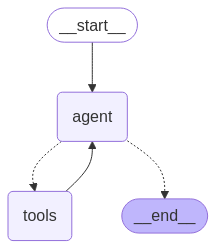

In [18]:
part_1_graph

In [19]:
import shutil
import uuid

# 튜토리얼 대화 예시 질문 목록
tutorial_questions = [
    "Hi there, what time is my flight?",
    "Am i allowed to update my flight to something sooner? I want to leave later today.",
    "Update my flight to sometime next week then",
    "The next available option is great",
    "what about lodging and transportation?",
    "Yeah i think i'd like an affordable hotel for my week-long stay (7 days). And I'll want to rent a car.",
    "OK could you place a reservation for your recommended hotel? It sounds nice.",
    "yes go ahead and book anything that's moderate expense and has availability.",
    "Now for a car, what are my options?",
    "Awesome let's just get the cheapest option. Go ahead and book for 7 days",
    "Cool so now what recommendations do you have on excursions?",
    "Are they available while I'm there?",
    "interesting - i like the museums, what options are there? ",
    "OK great pick one and book it for my second day there.",
]

# 날짜가 포함된 데이터베이스를 최신화
db = update_dates(db)

# 각 대화는 고유 thread_id를 기반으로 관리
thread_id = str(uuid.uuid4())

# 그래프 실행 설정 (사용자 고유 ID 및 스레드 ID 포함)
config = {
    # "callbacks": [handler],
    "configurable": {
        "passenger_id": "3442 587242",  # 사용자의 항공권 정보 조회에 사용됨
        "thread_id": thread_id,  # 체크포인트용 스레드 ID
    }
}

print("시작")
_printed = set()
# 예시 질문 순서대로 그래프 실행
for question in tutorial_questions:
    events = part_1_graph.stream(
        {"messages": ("user", question)}, config, stream_mode="values"
    )
    for event in events:
        _print_event(event, _printed)  # 이벤트 출력 (중복 방지)


시작
================================ Human Message =================================

Hi there, what time is my flight?
================================== Ai Message ==================================
Tool Calls:
  fetch_user_flight_information (call_UZLJViQaTIdXSXhhFNsokLHI)
 Call ID: call_UZLJViQaTIdXSXhhFNsokLHI
  Args:
[TOOL START] fetch_user_flight_information called with input: {}
================================= Tool Message =================================
Name: fetch_user_flight_information

[{"ticket_no": "7240005432906569", "book_ref": "C46E9F", "flight_id": 19250, "flight_no": "LX0112", "departure_airport": "CDG", "arrival_airport": "BSL", "scheduled_departure": "2025-05-06 16:53:06.750972-04:00", "scheduled_arrival": "2025-05-06 18:23:06.750972-04:00", "seat_no": "18E", "fare_conditions": "Economy"}]
================================== Ai Message ==================================

Your flight, LX0112, departs from Charles de Gaulle Airport (CDG) and arrives at EuroAirport

## Part 2: 확인 추가

Assistant가 사용자를 대신하여 어떤 행동을 취할 때, 사용자가 해당 행동을 최종 승인할 수 있어야 한다 (거의 항상). 그렇지 않으면, Assistant가 저지른 사소한 실수 하나나 prompt injection에 의해 발생한 오류가 사용자에게 실제적인 피해를 줄 수 있다.

이 섹션에서는 `interrupt_before`를 사용하여 그래프를 일시 중지하고, 어떤 도구를 실행하기 전에 사용자에게 제어권을 반환한다.

## State & Assistant 정의

우리의 그래프 상태와 LLM 호출은 Part 1과 거의 동일하지만 **예외**가 있습니다:

- `user_info` 필드를 추가했고, 이 필드는 그래프에 의해 eager하게 채워집니다.
- `Assistant` 객체에서는 configurable한 `params` 대신 상태(state)를 직접 사용할 수 있습니다.

## Graph 정의

Part 1에서의 문제점을 해결하기 위해 두 가지 변경점을 반영하여 그래프를 구성합니다:

1. 도구(tool)를 사용하기 전에 interrupt를 추가
2. 그래프의 첫 노드에서 `user_info` 상태를 명시적으로 채움 (Assistant가 사용자를 이해하기 위해 별도 도구를 호출할 필요 없음)


In [20]:
from langgraph.graph import StateGraph, START, END

class State(AgentState):
    passenger_id: str

def user_info(state: State):
    a = fetch_user_flight_information.invoke({})
    return {"passenger_id": a}

tool_node = ToolNode(tools=part_1_tools, handle_tool_errors=True)
memory = MemorySaver()

agent_graph = create_react_agent(
    tools=tools,
    model=llm,
    prompt=primary_assistant_prompt,
    checkpointer=memory,
    interrupt_before=["tools"],
)

builder = StateGraph(State)
builder.add_node("fetch_user_info", user_info)
builder.add_node("agent_graph", agent_graph)

builder.add_edge(START, "fetch_user_info")
builder.add_edge("fetch_user_info", "agent_graph")
builder.add_edge("agent_graph", END)

part_2_graph = builder.compile(
    checkpointer=memory
    )

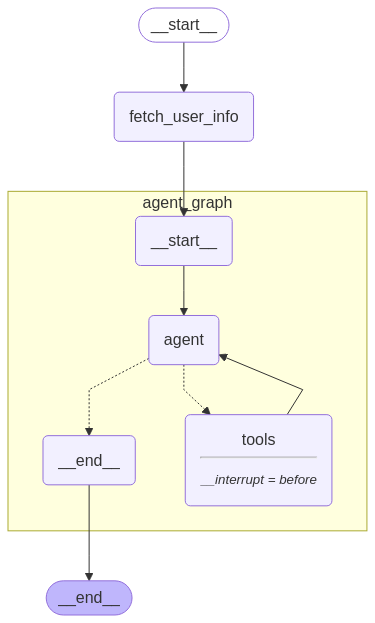

In [21]:
from IPython.display import Image, display

# Setting xray to 1 will show the internal structure of the nested graph
display(Image(part_2_graph.get_graph(xray=1).draw_mermaid_png()))


In [22]:
import shutil
import uuid

# 백업 파일을 이용하여 각 섹션마다 원래 위치에서 다시 시작할 수 있도록 업데이트합니다
db = update_dates(db)
thread_id = str(uuid.uuid4())

config = {
    "configurable": {
        # passenger_id는 flight 도구에서 사용자의 항공편 정보를 가져오는 데 사용됩니다
        "passenger_id": "3442 587242",
        # thread_id를 통해 체크포인트에 접근합니다
        "thread_id": thread_id,
    }
}


In [23]:
# _printed = set()
# # part 1에서 사용한 튜토리얼 질문을 재사용하여 성능을 확인할 수 있습니다.
# for question in tutorial_questions:
#     events = part_2_graph.stream(
#         {"messages": ("user", question)}, config, stream_mode="values", subgraphs=True
#     )
#     for _, event in events:
#         _print_event(event, _printed)
#     snapshot = part_2_graph.get_state(config)
#     while snapshot.next:
#         # 중단(interrupt)이 발생했습니다! 에이전트가 도구를 사용하려 하며, 사용자가 이를 승인하거나 거절할 수 있습니다
#         # 참고: 이 코드는 그래프 외부에 있습니다. 일반적으로는 출력값을 UI로 스트리밍합니다.
#         # 이후 사용자가 입력을 제공하면 프론트엔드가 API 호출을 통해 새 실행을 트리거합니다.
#         try:
#             # user_input = input(
#             #     "위 작업을 승인하시겠습니까? 계속하려면 'y'를 입력하세요; 그렇지 않으면 변경 요청 사항을 설명하세요.\n\n"
#             # )
#             print("위 작업을 승인하시겠습니까? 계속하려면 'y'를 입력하세요; 그렇지 않으면 변경 요청 사항을 설명하세요.")
#             print("y")
#             user_input = "y"
#         except:
#             user_input = "y"
#         if user_input == "y":
#             # 계속 진행
#             events = part_2_graph.stream(
#                 None,
#                 config, stream_mode="values", subgraphs=True
#             )
#             for _, event in events:
#                 _print_event(event, _printed)
#         else:
#             # 도구 호출을 만족시키기 위해
#             # 변경 요청 / 마음의 변화에 대한 설명을 제공합니다
#             result = part_2_graph.invoke(
#                 {
#                     "messages": [
#                         ToolMessage(
#                             tool_call_id=event["messages"][-1].tool_calls[0]["id"],
#                             content=f"API 호출이 사용자에 의해 거절되었습니다. 이유: '{user_input}'. 사용자의 입력을 반영하여 지원을 계속하세요.",
#                         )
#                     ]
#                 },
#                 config,
#             )
#         snapshot = part_2_graph.get_state(config)


In [24]:
# 읽기 전용 도구 (검색, 조회 등) - 사용자 확인 없이 자동 실행
part_3_safe_tools = [
    TavilySearchResults(max_results=1),
    fetch_user_flight_information,
    search_flights,
    lookup_policy,
    search_car_rentals,
    search_hotels,
    search_trip_recommendations,
]

# 사용자 예약에 영향을 주는 민감한 도구들 - 사용자 확인 필요
part_3_sensitive_tools = [
    update_ticket_to_new_flight,
    cancel_ticket,
    book_car_rental,
    update_car_rental,
    cancel_car_rental,
    book_hotel,
    update_hotel,
    cancel_hotel,
    book_excursion,
    update_excursion,
    cancel_excursion,
]

def has_sensitive_tool_call(event, sensitive_tools):
    # 도구 객체 리스트 → 이름 리스트로 변환
    sensitive_tool_names = {t.name for t in sensitive_tools}
    # tool_calls가 없으면 False
    tool_calls = event["messages"][-1].tool_calls
    for call in tool_calls:
        if call.get("name") in sensitive_tool_names:
            print("민감한 도구 호출이 포함되어 있습니다.")
            return True
    print("민감한 도구 호출이 없습니다.")
    return False

In [25]:
_printed = set()
# part 1에서 사용한 튜토리얼 질문을 재사용하여 성능을 확인할 수 있습니다.
for question in tutorial_questions:
    events = part_2_graph.stream(
        {"messages": ("user", question)}, config, stream_mode="values", subgraphs=True
    )
    for _, event in events:
        _print_event(event, _printed)
    snapshot = part_2_graph.get_state(config)
    while snapshot.next:
        # 중단(interrupt)이 발생했습니다! 에이전트가 도구를 사용하려 하며, 사용자가 이를 승인하거나 거절할 수 있습니다
        # 참고: 이 코드는 그래프 외부에 있습니다. 일반적으로는 출력값을 UI로 스트리밍합니다.
        # 이후 사용자가 입력을 제공하면 프론트엔드가 API 호출을 통해 새 실행을 트리거합니다.
        try:
            if has_sensitive_tool_call(event, part_3_sensitive_tools):
                user_input = input(
                    "위 작업을 승인하시겠습니까? 계속하려면 'y'를 입력하세요; 그렇지 않으면 변경 요청 사항을 설명하세요.\n\n"
                )
            else:
                user_input = "y"
        except:
            user_input = "y"
        if user_input == "y":
            # 계속 진행
            events = part_2_graph.stream(
                None,
                config, stream_mode="values", subgraphs=True
            )
            for _, event in events:
                _print_event(event, _printed)
        else:
            # 도구 호출을 만족시키기 위해
            # 변경 요청 / 마음의 변화에 대한 설명을 제공합니다
            result = part_2_graph.invoke(
                {
                    "messages": [
                        ToolMessage(
                            tool_call_id=event["messages"][-1].tool_calls[0]["id"],
                            content=f"API 호출이 사용자에 의해 거절되었습니다. 이유: '{user_input}'. 사용자의 입력을 반영하여 지원을 계속하세요.",
                        )
                    ]
                },
                config,
            )
        snapshot = part_2_graph.get_state(config)


================================ Human Message =================================

Hi there, what time is my flight?
================================== Ai Message ==================================
Tool Calls:
  fetch_user_flight_information (call_qZt4nPBmoaZY4teoDVY1dtiF)
 Call ID: call_qZt4nPBmoaZY4teoDVY1dtiF
  Args:
민감한 도구 호출이 없습니다.
================================= Tool Message =================================
Name: fetch_user_flight_information

[{"ticket_no": "7240005432906569", "book_ref": "C46E9F", "flight_id": 19250, "flight_no": "LX0112", "departure_airport": "CDG", "arrival_airport": "BSL", "scheduled_departure": "2025-05-06 16:53:55.018658-04:00", "scheduled_arrival": "2025-05-06 18:23:55.018658-04:00", "seat_no": "18E", "fare_conditions": "Economy"}]
================================== Ai Message ==================================

Your flight details are as follows:

- **Flight Number:** LX0112
- **Departure Airport:** CDG (Charles de Gaulle Airport)
- **Arrival Airport:*

In [55]:
events

1


In [ ]:
raise Exception

In [ ]:
_printed = set()
# part 1에서 사용한 튜토리얼 질문을 재사용하여 성능을 확인할 수 있습니다.
for question in tutorial_questions:
    events = part_2_graph.stream(
        {"messages": ("user", question)}, config, stream_mode="values"
    )
    for event in events:
        _print_event(event, _printed)
    snapshot = part_2_graph.get_state(config)
    while snapshot.next:
        # 중단(interrupt)이 발생했습니다! 에이전트가 도구를 사용하려 하며, 사용자가 이를 승인하거나 거절할 수 있습니다
        # 참고: 이 코드는 그래프 외부에 있습니다. 일반적으로는 출력값을 UI로 스트리밍합니다.
        # 이후 사용자가 입력을 제공하면 프론트엔드가 API 호출을 통해 새 실행을 트리거합니다.
        try:
            # user_input = input(
            #     "위 작업을 승인하시겠습니까? 계속하려면 'y'를 입력하세요; 그렇지 않으면 변경 요청 사항을 설명하세요.\n\n"
            # )
            user_input = "y"
        except:
            user_input = "y"
        if user_input.strip() == "y":
            # 계속 진행
            result = part_2_graph.invoke(
                None,
                config,
            )
        else:
            # 도구 호출을 만족시키기 위해
            # 변경 요청 / 마음의 변화에 대한 설명을 제공합니다
            result = part_2_graph.invoke(
                {
                    "messages": [
                        ToolMessage(
                            tool_call_id=event["messages"][-1].tool_calls[0]["id"],
                            content=f"API 호출이 사용자에 의해 거절되었습니다. 이유: '{user_input}'. 사용자의 입력을 반영하여 지원을 계속하세요.",
                        )
                    ]
                },
                config,
            )
        snapshot = part_2_graph.get_state(config)
